# Проект: классификация

In [472]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [473]:
df = pd.read_csv('C:/Users/Кирилл/Downloads/bank_fin/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [474]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.info()
print(f'Количество пропущенных значений: {df.isna().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB
Количество пропущенных значений: age           0
job           0
marital       0
education     0
de

### Задание 2

In [475]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
print(df['job'].unique())


['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']


Мы видим в признаке работы слово unknown, что является пропусками

### Задание 3

In [476]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].str.replace(r'[\$\s]', '', regex=True).str.replace(',', '.').astype(float)
# Рассчитываем среднее значение по столбцу 'balance'
mean_balance = df['balance'].mean()

# Округляем до 3 знаков после запятой
print(f"Среднее значение по столбцу 'balance': {mean_balance:.3f}")

Среднее значение по столбцу 'balance': 1529.129


### Задание 4

In [477]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df['balance'].median())
df.describe()


,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1526.936033,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3224.829691,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,123.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1699.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


### Задание 5

In [478]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df['job'] = df['job'].replace('unknown', df['job'].mode()[0])
df['education'] = df['education'].replace('unknown', df['education'].mode()[0])

### Задание 6

In [479]:
# удалите все выбросы для признака balance
# ваш код
# Рассчитываем квартильные значения
Q1 = np.percentile(df['balance'], 25)
Q3 = np.percentile(df['balance'], 75)

# Рассчитываем межквартильный размах
IQR = Q3 - Q1

# Вычисляем нижнюю и верхнюю границы для поиска выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Округляем границы до целых чисел
lower_bound = round(lower_bound)
upper_bound = round(upper_bound)

print(f'Нижняя граница: {lower_bound}')
print(f'Верхняя граница: {upper_bound}')

# Применяем фильтрацию для удаления выбросов
filtered_df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

# Выводим размер отфильтрованного DataFrame
print(f'Количество строк после удаления выбросов: {filtered_df.shape[0]}')

Нижняя граница: -2241
Верхняя граница: 4063
Количество строк после удаления выбросов: 10105


In [480]:
df = filtered_df.copy()

## Часть 2:  Разведывательный анализ

### Задание 1

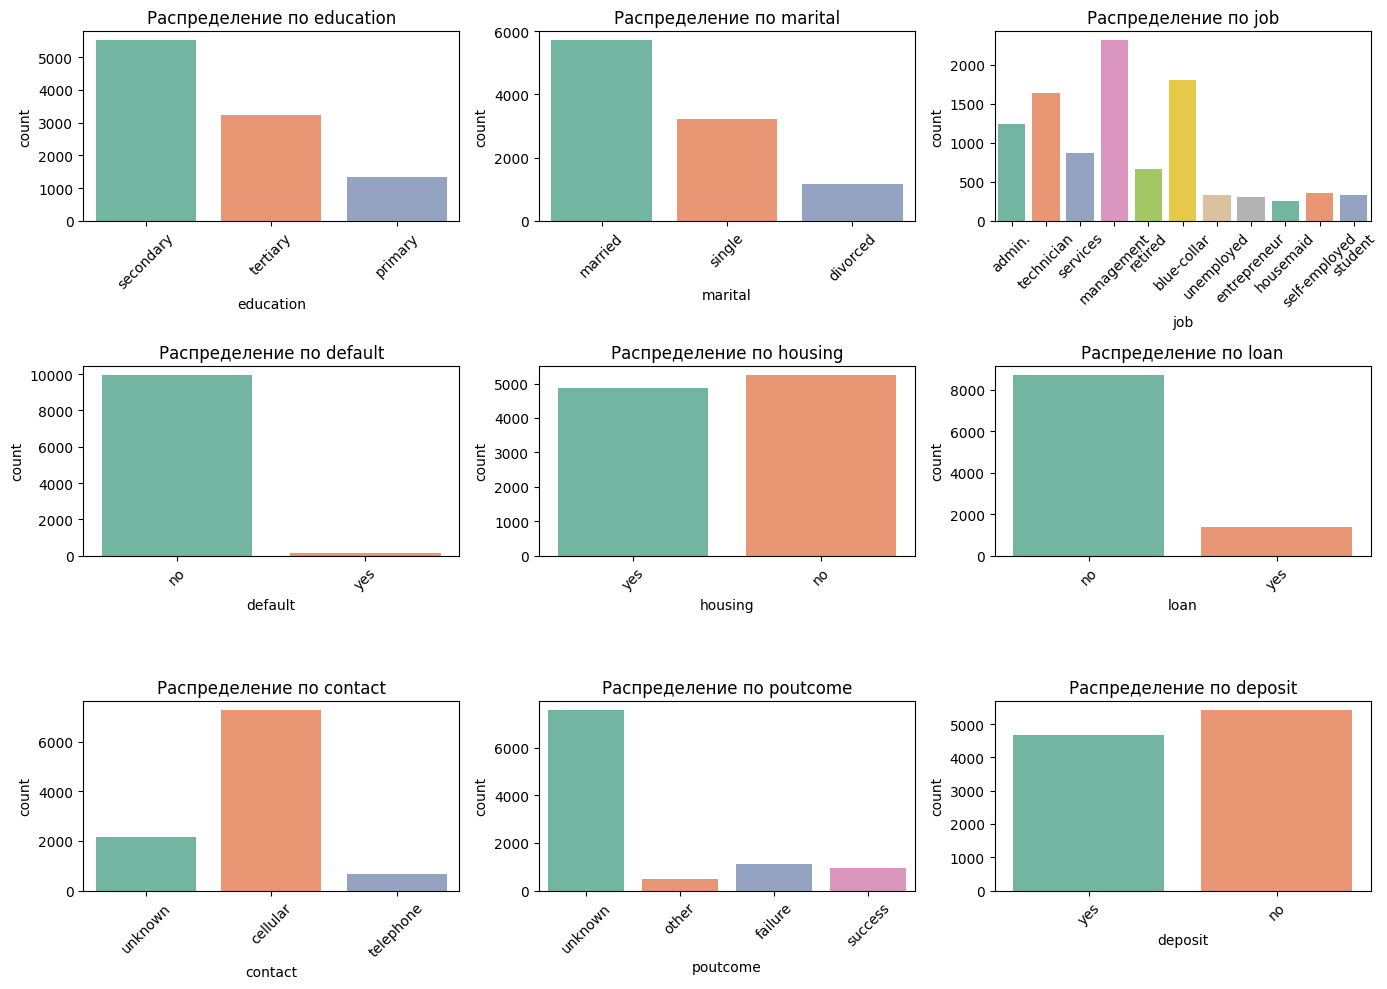

In [481]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
categorical_columns = ['education', 'marital', 'job', 'default', 'housing', 'loan', 'contact', 'poutcome', 'deposit']

# Строим графики для каждого категориального признака
plt.figure(figsize=(14, 10))

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(3, 3, i)  # Создаём сетку из графиков (3 ряда по 3 столбца)
    sns.countplot(x=column, data=df, palette="Set2")
    plt.title(f'Распределение по {column}')
    plt.xticks(rotation=45)  # Поворот подписей

plt.tight_layout()  # Корректировка расстояний между графиками
plt.show()

In [482]:
balanced_classes = ['deposit', 'housing']

### Задания 2 и 3

In [483]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [484]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
categorical_columns = ['education', 'marital', 'job', 'default', 'housing', 'loan', 'contact', 'poutcome', 'deposit']

# Вывод частот для каждого категориального столбца
for column in categorical_columns:
    print(f"Описание для столбца {column}:")
    print(df[column].value_counts(normalize=True))  # Нормализованное распределение
    print("\n")

Описание для столбца education:
education
secondary    0.545967
tertiary     0.320534
primary      0.133498
Name: proportion, dtype: float64


Описание для столбца marital:
marital
married     0.565562
single      0.317961
divorced    0.116477
Name: proportion, dtype: float64


Описание для столбца job:
job
management       0.229095
blue-collar      0.178822
technician       0.162098
admin.           0.123305
services         0.085898
retired          0.065611
self-employed    0.035428
unemployed       0.032855
student          0.032261
entrepreneur     0.029688
housemaid        0.024938
Name: proportion, dtype: float64


Описание для столбца default:
default
no     0.983572
yes    0.016428
Name: proportion, dtype: float64


Описание для столбца housing:
housing
no     0.518852
yes    0.481148
Name: proportion, dtype: float64


Описание для столбца loan:
loan
no     0.862147
yes    0.137853
Name: proportion, dtype: float64


Описание для столбца contact:
contact
cellular     0.720732
u

### Задание 6

In [485]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
# Группируем по 'poutcome' и считаем количество успешных и неуспешных случаев
campaign_results = df.groupby('poutcome')['deposit'].value_counts().unstack()

campaign_results.columns = ['no', 'yes']

# Вычисляем разницу между успехами и неудачами
campaign_results['success_over_failures'] = campaign_results['yes'] - campaign_results['no']

# Выводим статус(ы), где успехов больше, чем неудач
successful_poutcome = campaign_results[campaign_results['success_over_failures'] > 0]

print(successful_poutcome)

           no  yes  success_over_failures
poutcome                                 
other     216  265                     49
success    84  861                    777


### Задание 7

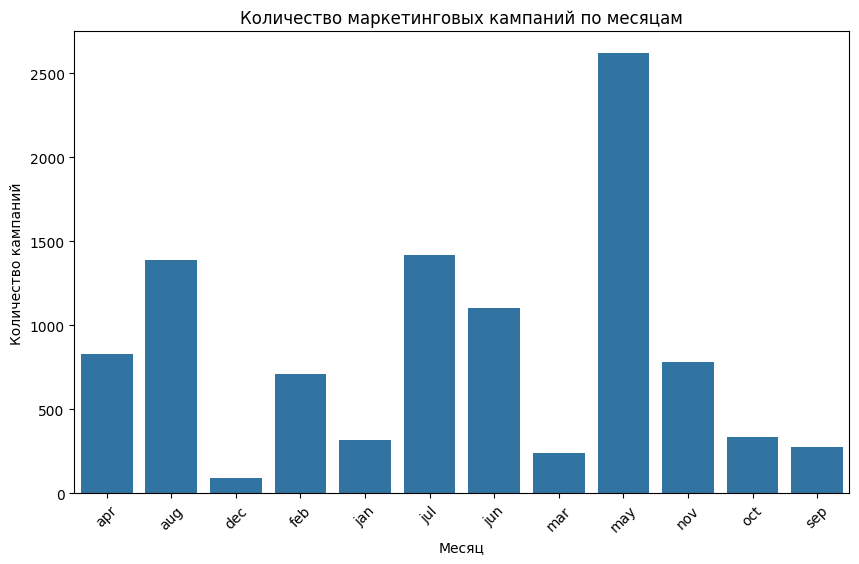

In [486]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
df_campaign = df[df['campaign'] > 0]

# Группируем данные по месяцу и считаем количество кампаний
campaign_per_month = df_campaign.groupby('month')['campaign'].count()

# Строим визуализацию
plt.figure(figsize=(10,6))
sns.barplot(x=campaign_per_month.index, y=campaign_per_month.values)
plt.title('Количество маркетинговых кампаний по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество кампаний')
plt.xticks(rotation=45)
plt.show()

### Задание 8

In [487]:

df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
#копируем дф для выполнения промежуточного задания
df1 = df.copy()
# Добавляем столбец с возрастными группами


# Группируем по возрастным категориям и считаем количество успешных и неуспешных случаев
age_deposit = df1.groupby('age_group')['deposit'].value_counts().unstack()


# Вычисляем разницу между успехами и неудачами
age_deposit['success_over_failures'] = age_deposit['yes'] - age_deposit['no']

# Выводим возрастные группы, где успехов больше, чем отказов
successful_age_groups = age_deposit[age_deposit['success_over_failures'] > 0]
#df = df.drop('age', axis = 1)
print(successful_age_groups)

deposit     no   yes  success_over_failures
age_group                                  
<30        819  1051                    232
60+         97   416                    319


### Задания 9 и 10

<Figure size 800x600 with 0 Axes>

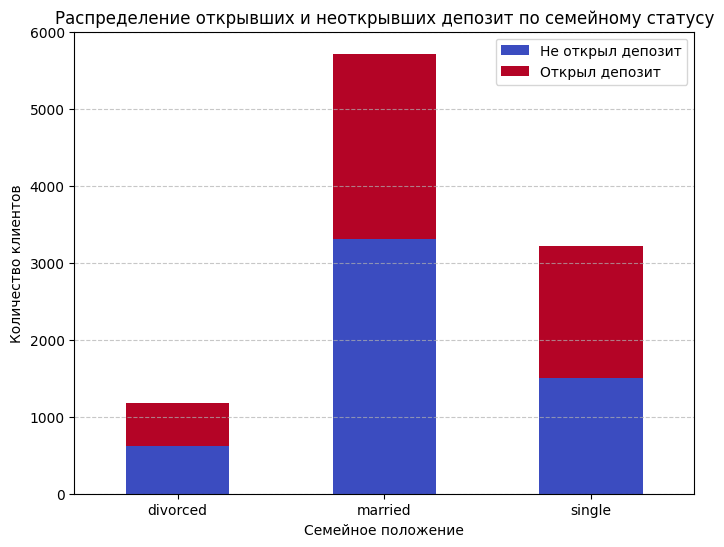

In [488]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
# Подсчет количества открывших и неоткрывших депозит в разрезе семейного статуса
marital_deposit = df.groupby(['marital', 'deposit']).size().unstack()

# Построение столбчатой диаграммы
plt.figure(figsize=(8, 6))
marital_deposit.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(8, 6))

# Настройка подписей
plt.title("Распределение открывших и неоткрывших депозит по семейному статусу")
plt.xlabel("Семейное положение")
plt.ylabel("Количество клиентов")
plt.legend(["Не открыл депозит", "Открыл депозит"])
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

<Figure size 800x600 with 0 Axes>

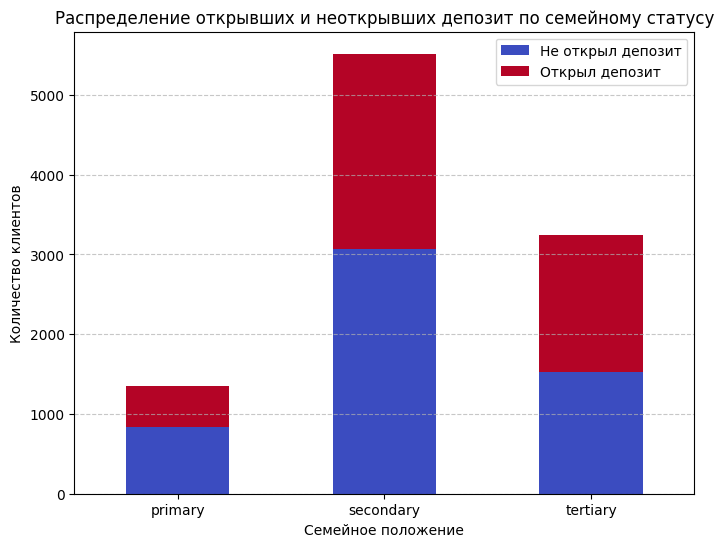

In [489]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
# Подсчет количества открывших и неоткрывших депозит в разрезе семейного статуса
marital_deposit = df.groupby(['education', 'deposit']).size().unstack()

# Построение столбчатой диаграммы
plt.figure(figsize=(8, 6))
marital_deposit.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(8, 6))

# Настройка подписей
plt.title("Распределение открывших и неоткрывших депозит по семейному статусу")
plt.xlabel("Семейное положение")
plt.ylabel("Количество клиентов")
plt.legend(["Не открыл депозит", "Открыл депозит"])
plt.xticks(rotation=0) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

<Figure size 1200x600 with 0 Axes>

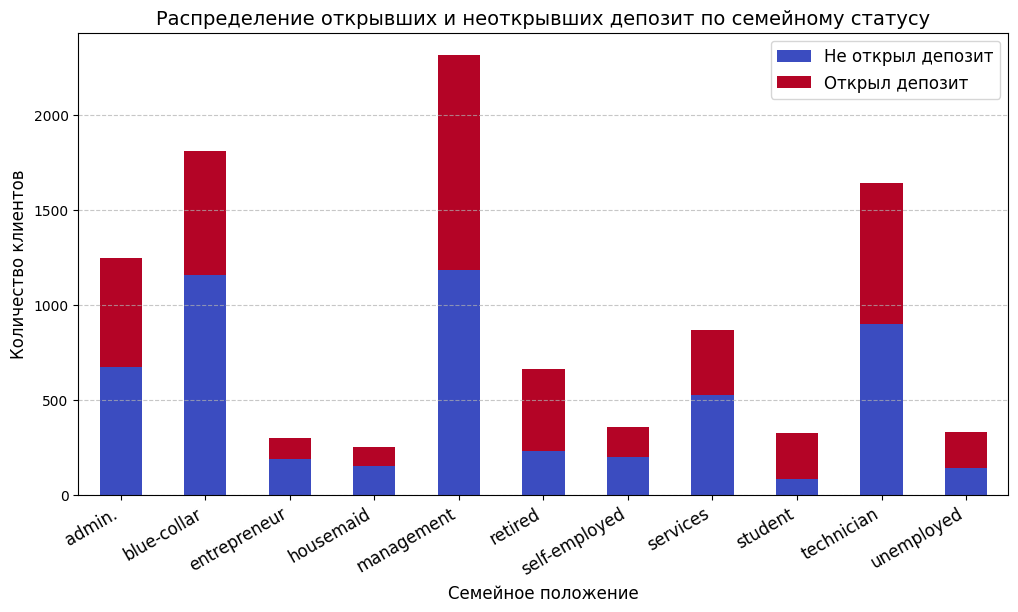

In [490]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

# Подсчет количества открывших и неоткрывших депозит в разрезе семейного статуса
marital_deposit = df.groupby(['job', 'deposit']).size().unstack()


plt.figure(figsize=(12, 6))  

# Построение диаграммы
marital_deposit.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(12, 6))

# Настройка подписей
plt.title("Распределение открывших и неоткрывших депозит по семейному статусу", fontsize=14)
plt.xlabel("Семейное положение", fontsize=12)
plt.ylabel("Количество клиентов", fontsize=12)
plt.legend(["Не открыл депозит", "Открыл депозит"], fontsize=12)

# Поворачиваем подписи на 30 градусов для лучшей читаемости
plt.xticks(rotation=30, ha="right", fontsize=12)  

plt.grid(axis='y', linestyle='--', alpha=0.7)  # Добавляем сетку для удобства
plt.show()

### Задание 11

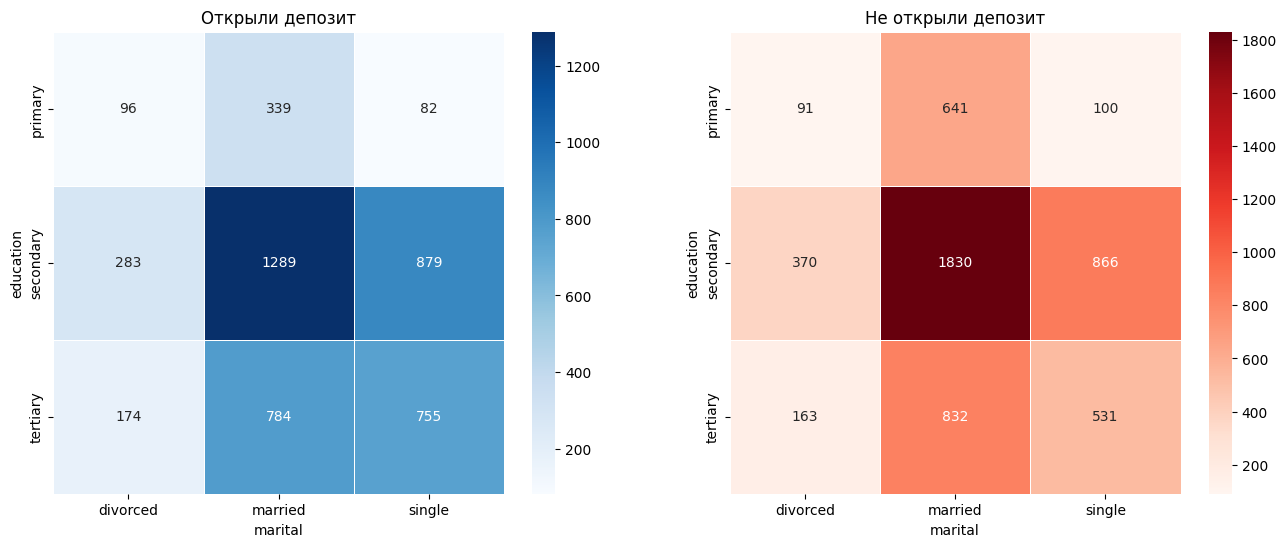

In [491]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

# Разделяем данные по признаку открытия депозита
df_yes = df[df['deposit'] == 'yes']
df_no = df[df['deposit'] == 'no']

# Создаём сводные таблицы
pivot_yes = pd.crosstab(df_yes['education'], df_yes['marital'])
pivot_no = pd.crosstab(df_no['education'], df_no['marital'])

# Настраиваем размер графиков
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Визуализация тепловой карты для открывших депозит
sns.heatmap(pivot_yes, annot=True, fmt="d", cmap="Blues", linewidths=0.5, ax=axes[0])
axes[0].set_title("Открыли депозит")

# Визуализация тепловой карты для неоткрывших депозит
sns.heatmap(pivot_no, annot=True, fmt="d", cmap="Reds", linewidths=0.5, ax=axes[1])
axes[1].set_title("Не открыли депозит")

plt.show()


## Часть 3: преобразование данных

### Задание 1

In [492]:
# преобразуйте уровни образования
# преобразуйте уровни образования
label_encoder = LabelEncoder()

# Применяем преобразование к столбцу 'education'
df['education_encoded'] = label_encoder.fit_transform(df['education'])

# Проверяем результат
print(df[['education', 'education_encoded']].head())
print(sum(df['education_encoded']))

#df = df.drop('education', axis = 1)

   education  education_encoded
0  secondary                  1
1  secondary                  1
2  secondary                  1
3  secondary                  1
4   tertiary                  2
11995


### Задания 2 и 3

In [493]:
# преобразуйте бинарные переменные в представление из нулей и единиц
binary_columns = ['deposit', 'default', 'housing', 'loan']

# Преобразуем "yes" в 1, "no" в 0
for col in binary_columns:
    df[col] = df[col].map({'yes': 1, 'no': 0})

# Проверяем результат
print(df[binary_columns].head())
print(f'Стандартное отклонение по deposit: {df['deposit'].std()}')
print(f"Среднее арифмитическое: {df['default'].mean() + df['housing'].mean()+ df['loan'].mean()}")
#df = df.drop(binary_columns, axis = 1)

   deposit  default  housing  loan
0        1        0        1     0
1        1        0        0     0
2        1        0        1     0
3        1        0        1     0
4        1        0        0     0
Стандартное отклонение по deposit: 0.4986712532452124
Среднее арифмитическое: 0.6354280059376547


### Задание 4

In [494]:
# создайте дамми-переменные
# Определяем категориальные столбцы (кроме бинарных)
categorical_columns = ['job', 'marital', 'contact', 'month', 'poutcome', 'age_group']

# Преобразуем их в дамми-переменные
df = pd.get_dummies(df, columns=categorical_columns, drop_first=False, dtype=int)

# Проверяем результат
print(df)

       age  education  default  balance  housing  loan  day  duration  \
0       59  secondary        0   2343.0        1     0    5      1042   
1       56  secondary        0     45.0        0     0    5      1467   
2       41  secondary        0   1270.0        1     0    5      1389   
3       55  secondary        0   2476.0        1     0    5       579   
4       54   tertiary        0    184.0        0     0    5       673   
...    ...        ...      ...      ...      ...   ...  ...       ...   
11157   33    primary        0      1.0        1     0   20       257   
11158   39  secondary        0    733.0        0     0   16        83   
11159   32  secondary        0     29.0        0     0   19       156   
11160   43  secondary        0      0.0        0     1    8         9   
11161   34  secondary        0      0.0        0     0    9       628   

       campaign  pdays  ...  month_sep  poutcome_failure  poutcome_other  \
0             1     -1  ...          0         

### Задания 5 и 6

<Figure size 3000x2000 with 0 Axes>

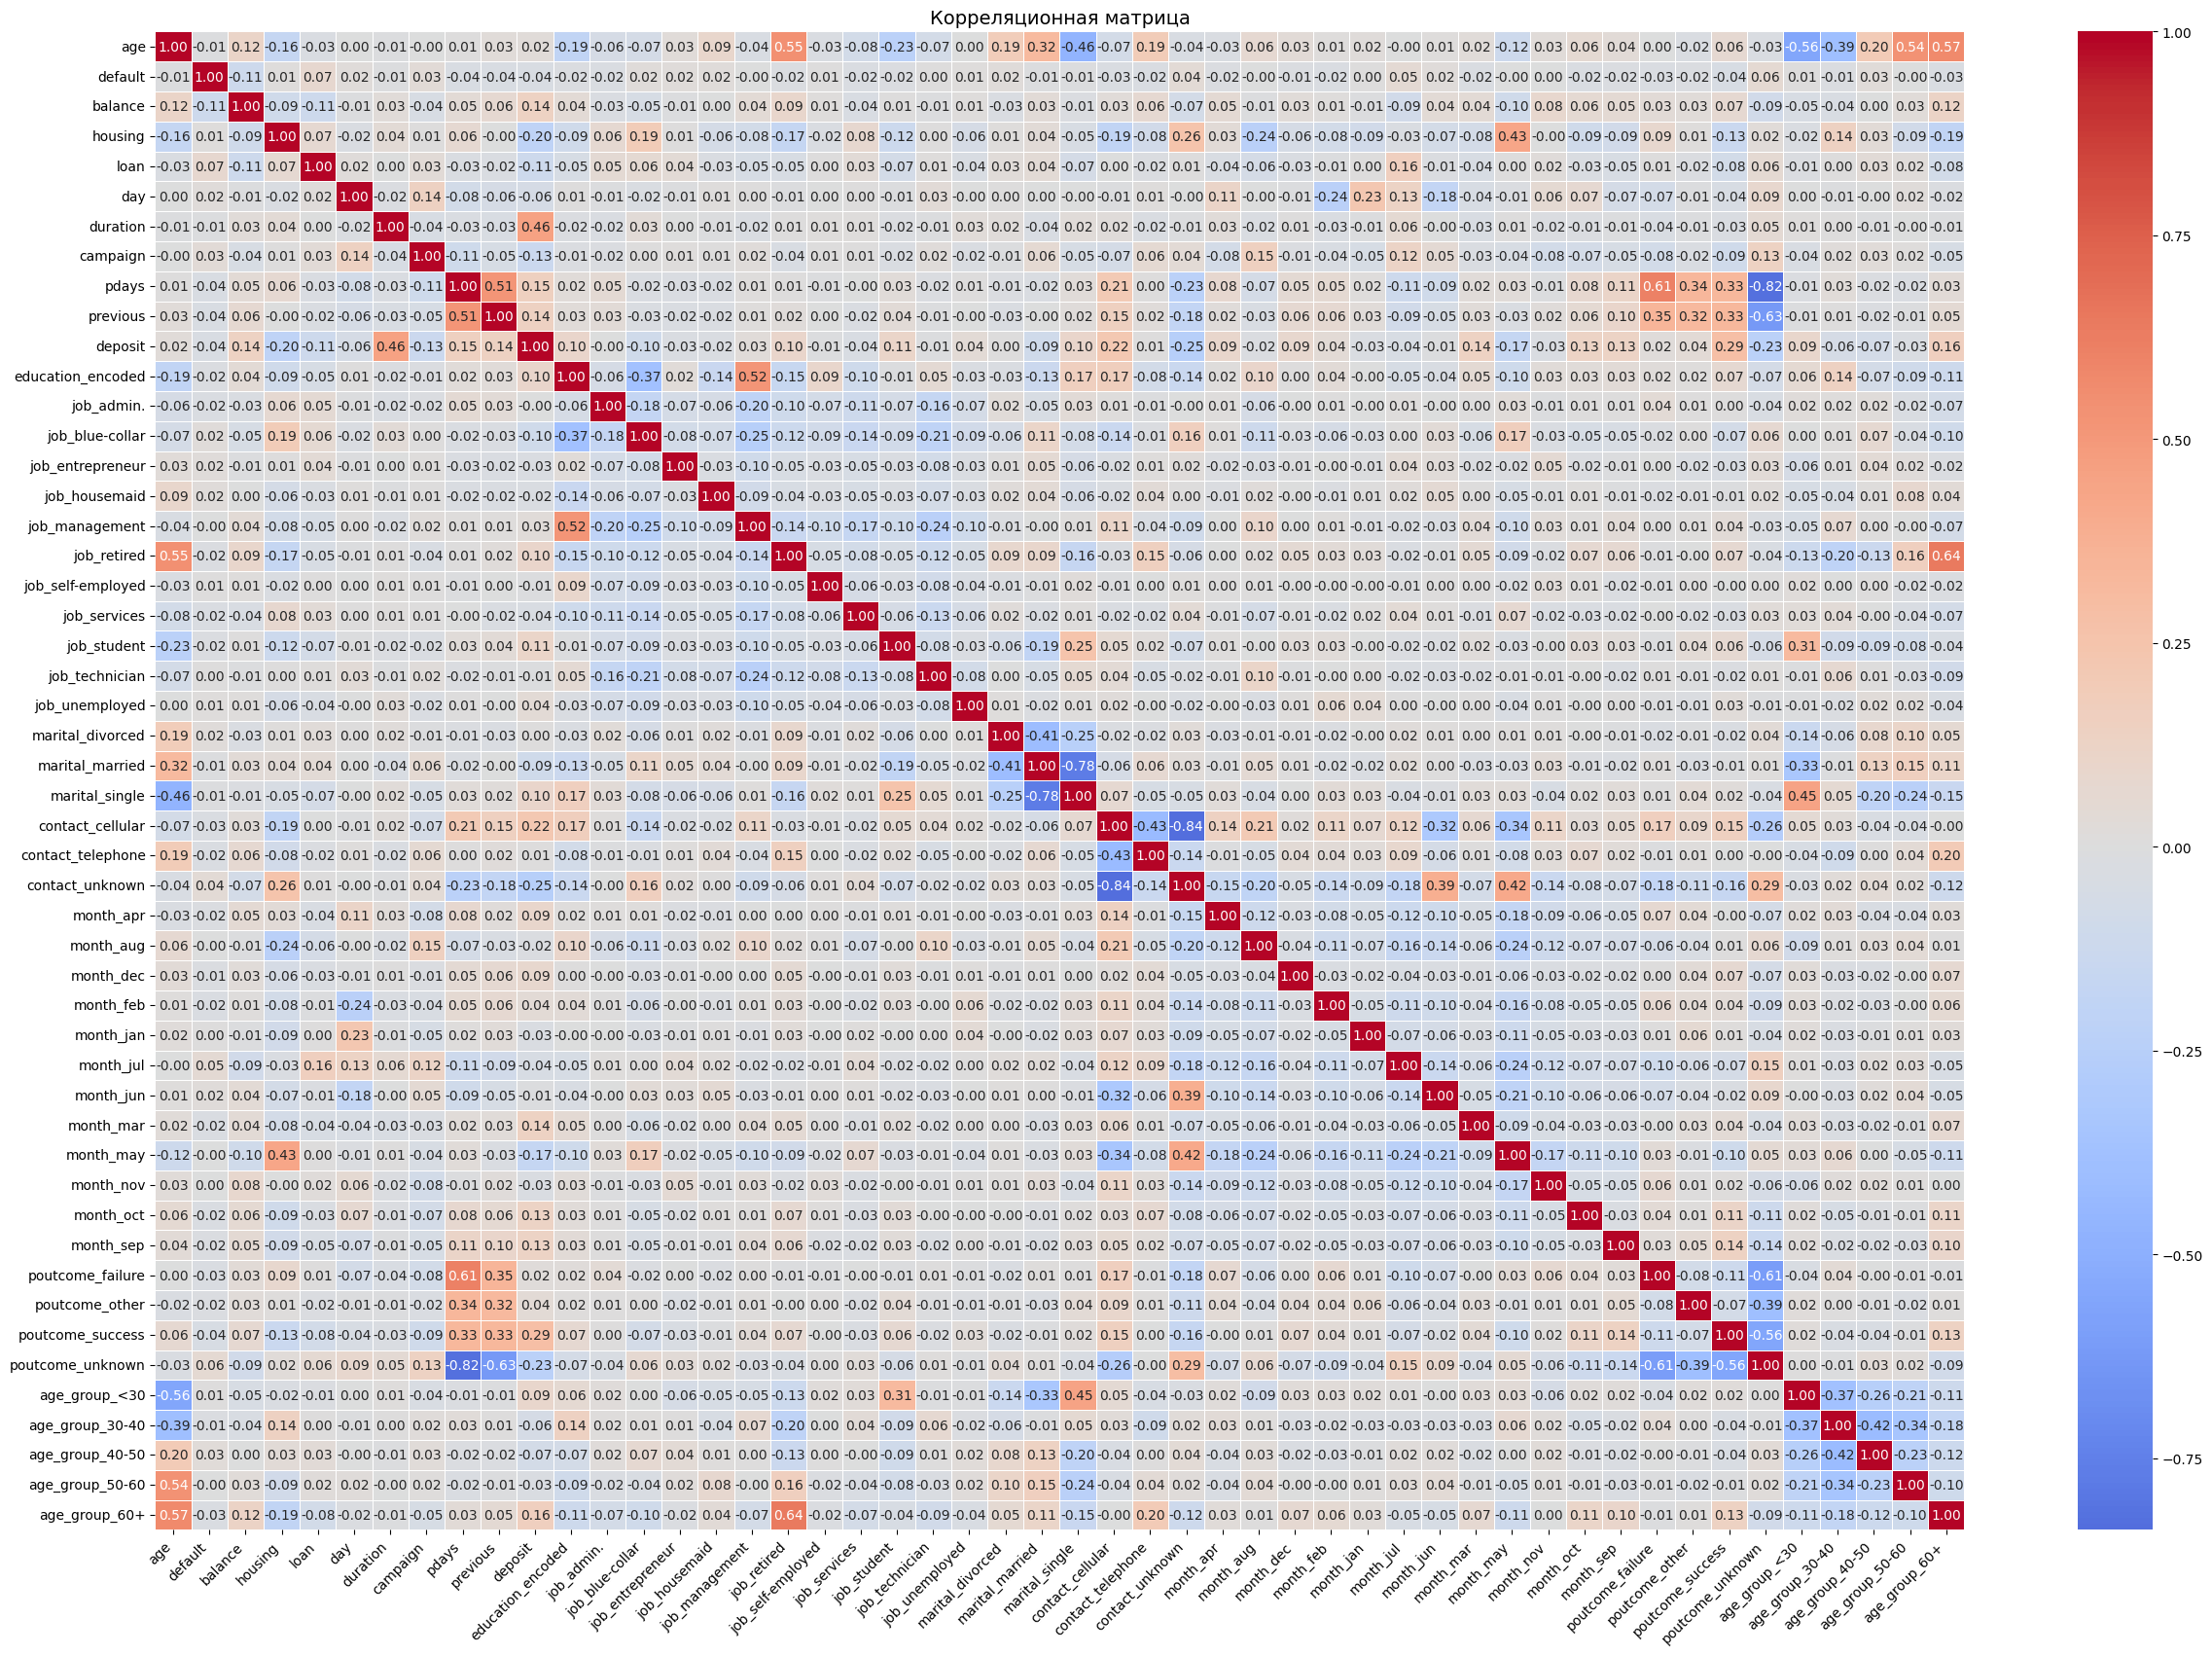

In [495]:
plt.figure(figsize=(30, 20))  # Увеличиваем размер
# Выбираем только числовые столбцы
numeric_df = df.select_dtypes(include=['number'])

# Строим тепловую карту корреляции
plt.figure(figsize=(30, 20))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, center=0)
plt.xticks(rotation=45, ha="right")  # Поворачиваем подписи столбцов
plt.yticks(rotation=0)  # Выравниваем строки
plt.title("Корреляционная матрица", fontsize=14)  # Заголовок
plt.show()


### Задания 7 и 8

In [496]:
X = numeric_df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [497]:
print(f'Размер тестовой выборки: {X_test.shape[0]} строк, {X_test.shape[1]} столбцов')

Размер тестовой выборки: 3335 строк, 49 столбцов


In [498]:
# рассчитайте необходимые показатели
print('Распределение классов в y_train:')
print(y_train.value_counts(normalize=True))
print('Распределение классов в y_test:')
print(y_test.value_counts(normalize=True))


Распределение классов в y_train:
deposit
0    0.53678
1    0.46322
Name: proportion, dtype: float64
Распределение классов в y_test:
deposit
0    0.536732
1    0.463268
Name: proportion, dtype: float64


In [499]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Оценка качества
print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 0.800
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1790
           1       0.80      0.75      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



### Задание 9

In [500]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_classif

# Применяем SelectKBest с критерием f_classif
selector = SelectKBest(score_func=f_classif, k=15)  # Оставляем 15 лучших признаков
X_selected = selector.fit_transform(X_train, y_train)

# Получаем список отобранных признаков
selected_features = X_train.columns[selector.get_support()]

# Выводим отобранные признаки
print("Отобранные признаки:", selected_features.tolist())

# Таблица значимости признаков
feature_scores = pd.DataFrame({'Feature': X_train.columns, 'Score': selector.scores_})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

print("Топ-15 признаков:")
print(feature_scores.head(15))


Отобранные признаки: ['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown', 'age_group_60+']
Топ-15 признаков:
             Feature        Score
6           duration  1839.078214
42  poutcome_success   628.351616
27   contact_unknown   427.557659
43  poutcome_unknown   373.006765
25  contact_cellular   350.501992
3            housing   301.264198
36         month_may   183.875989
48     age_group_60+   178.435493
9           previous   153.923796
8              pdays   148.749979
7           campaign   139.486664
39         month_sep   130.230009
38         month_oct   125.319693
35         month_mar   114.759591
2            balance   114.356404


### Задание 10

In [501]:
mean_first_feature = X_test.iloc[:, 0].mean()
print(mean_first_feature)


41.15982008995502


In [502]:
# нормализуйте данные с помощью minmaxsxaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Нормализация обучающей выборки
X_train_scaled = scaler.fit_transform(X_train)

# Нормализация тестовой выборки (используем параметры, найденные на train)
X_test_scaled = scaler.transform(X_test)
mean_first_feature = X_test_scaled[:, 0].mean()
print(round(mean_first_feature, 2))


0.31


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [503]:
# обучите логистическую регрессию и рассчитайте метрики качества
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Создаём и обучаем модель
model = LogisticRegression(solver='sag', random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Делаем предсказания
y_pred = model.predict(X_test_scaled)

# Оцениваем качество модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(accuracy, 2)}')


Accuracy: 0.82


### Задания 2,3,4

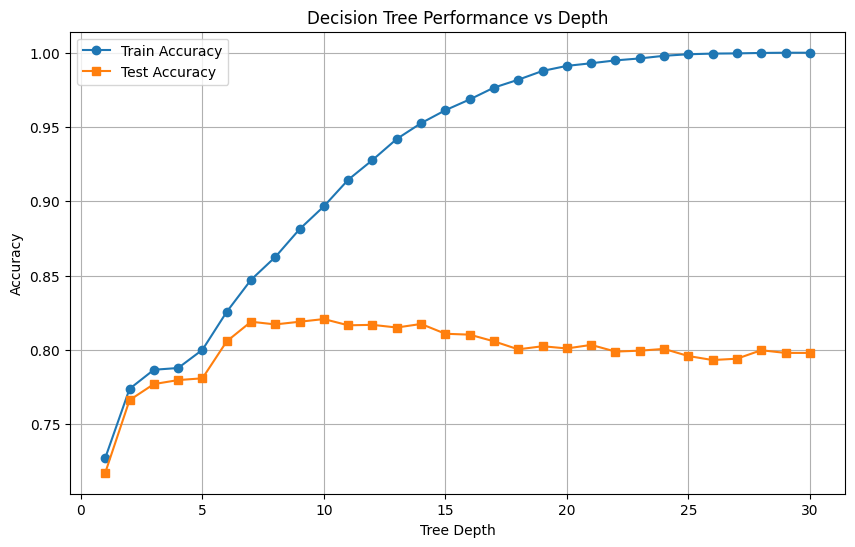

🔹 Оптимальная глубина дерева: 10
🔹 Точность на обучающей выборке: 0.8966
🔹 Точность на тестовой выборке: 0.8207


In [504]:
# обучите решающие деревья, настройте максимальную глубину
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

depths = range(1, 31)  # Проверяем глубины от 1 до 20
train_scores = []
test_scores = []

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    train_scores.append(accuracy_score(y_train, y_train_pred))
    test_scores.append(accuracy_score(y_test, y_test_pred))

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, marker='o', label='Train Accuracy')
plt.plot(depths, test_scores, marker='s', label='Test Accuracy')

plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Performance vs Depth')
plt.legend()
plt.grid()
plt.show()
# Находим индекс с максимальной точностью на тестовых данных
best_index = np.argmax(test_scores)
best_depth = depths[best_index]
best_train_acc = train_scores[best_index]
best_test_acc = test_scores[best_index]

print(f"🔹 Оптимальная глубина дерева: {best_depth}")
print(f"🔹 Точность на обучающей выборке: {best_train_acc:.4f}")
print(f"🔹 Точность на тестовой выборке: {best_test_acc:.4f}")


### Задание 5

In [505]:
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Определяем параметры для подбора
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
}

# Создаем модель
dt = DecisionTreeClassifier(random_state=42)

# Ищем лучшие параметры с учетом F1-score
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Выводим лучшие параметры и F1-метрику на кросс-валидации
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая F1-метрика на кросс-валидации:", grid_search.best_score_)

# Обучаем модель с лучшими параметрами
best_model = grid_search.best_estimator_

# Делаем предсказания на тестовых данных
y_test_pred = best_model.predict(X_test_scaled)

# Оцениваем F1-score на тесте
test_f1 = f1_score(y_test, y_test_pred)
print("F1-метрика на тестовых данных:", test_f1)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшие параметры: {'max_depth': 7, 'min_samples_split': 2}
Лучшая F1-метрика на кросс-валидации: 0.7948114438397617
F1-метрика на тестовых данных: 0.8105395232120451


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [513]:
# обучите на ваших данных случайный лес
from sklearn.ensemble import RandomForestClassifier

# Создаем модель случайного леса с лучшими параметрами из решающего дерева
rf = RandomForestClassifier(
    n_estimators=100,  # Количество деревьев в лесу
    criterion='gini',  
    max_depth=10,  
    min_samples_leaf=5,   
    random_state=42,  
    n_jobs=-1  # Используем все ядра процессора для ускорения
)

# Обучаем модель
rf.fit(X_train_scaled, y_train)

# Оцениваем качество модели
train_accuracy = rf.score(X_train_scaled, y_train)
test_accuracy = rf.score(X_test_scaled, y_test)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")
print(f'F1 на тестеЖ {test_f1}')


Точность на обучающей выборке: 0.8736
Точность на тестовой выборке: 0.8372
F1 на тестеЖ 0.8105395232120451


### Задания 2 и 3

In [512]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

# Создаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    n_estimators=100,    # Количество деревьев
    learning_rate=0.05,   # Скорость обучения
    max_depth=5,         # Глубина деревьев
    min_samples_leaf=5,    
    random_state=42
)

# Обучаем модель
gb.fit(X_train_scaled, y_train)

# Оцениваем качество модели
train_accuracy_gb = gb.score(X_train_scaled, y_train)
test_accuracy_gb = gb.score(X_test_scaled, y_test)

print(f"Точность градиентного бустинга на обучающей выборке: {train_accuracy_gb:.4f}")
print(f"Точность градиентного бустинга на тестовой выборке: {test_accuracy_gb:.4f}")
print(f"Точность случайного леса на тесте: {test_accuracy:.4f}")

Точность градиентного бустинга на обучающей выборке: 0.8770
Точность градиентного бустинга на тестовой выборке: 0.8453
Точность случайного леса на тесте: 0.8372


### Задание 4

In [508]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
# Базовые модели
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=11, min_samples_leaf=4, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('svc', make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True)))
]
# Мета-модель (логистическая регрессия)
meta_model = LogisticRegression(max_iter=1000, random_state=42)
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    stack_method='auto'
)
# Обучаем модель стекинга
stacking_clf.fit(X_train, y_train)

# Оцениваем точность на тестовой выборке
train_accuracy_stacking = stacking_clf.score(X_train, y_train)
test_accuracy_stacking = stacking_clf.score(X_test, y_test)

print(f"Точность стекинга на обучающей выборке: {train_accuracy_stacking:.4f}")
print(f"Точность стекинга на тестовой выборке: {test_accuracy_stacking:.4f}")
print(f"Точность случайного леса: {test_accuracy:.4f}")
print(f"Точность градиентного бустинга: {test_accuracy_gb:.4f}")
print(f"Точность стекинга: {test_accuracy_stacking:.4f}")


Точность стекинга на обучающей выборке: 0.8746
Точность стекинга на тестовой выборке: 0.8414
Точность случайного леса: 0.8414
Точность градиентного бустинга: 0.8381
Точность стекинга: 0.8414


### Задание 5

              Feature  Importance
6            duration    0.332537
42   poutcome_success    0.101834
5                 day    0.078686
2             balance    0.061901
27    contact_unknown    0.054817
0                 age    0.047994
8               pdays    0.032330
3             housing    0.031409
7            campaign    0.019942
33          month_jul    0.017879
31          month_feb    0.013303
29          month_aug    0.013278
10  education_encoded    0.013185
37          month_nov    0.012605
35          month_mar    0.011171
24     marital_single    0.009759
9            previous    0.009206
38          month_oct    0.009173
34          month_jun    0.008903
20     job_technician    0.008535
28          month_apr    0.008229
4                loan    0.007636
36          month_may    0.007569
32          month_jan    0.007231
39          month_sep    0.006482
11         job_admin.    0.005829
16        job_retired    0.005627
18       job_services    0.005621
22   marital_d

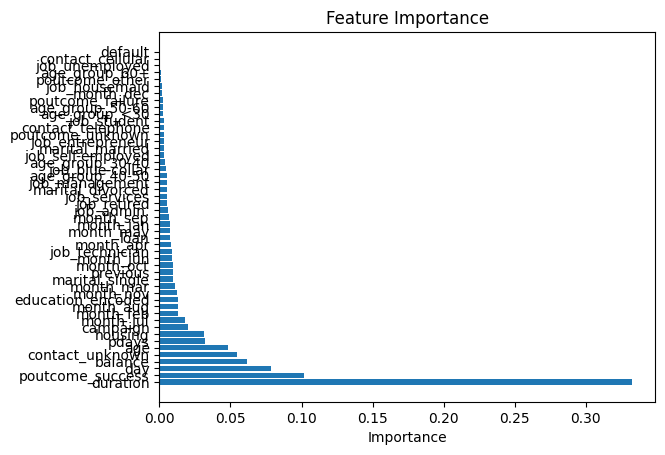

In [515]:
    # оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
# Получение важности признаков
feature_importance = model.feature_importances_

# Создание DataFrame для удобства
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Сортировка признаков по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

import matplotlib.pyplot as plt

# Визуализация важности признаков
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

### Задания 6,7,8

In [ ]:
import optuna
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def objective(trial):
    # Предлагаем гиперпараметры
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # Создаем модель с предложенными гиперпараметрами
    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Обучаем модель
    model.fit(X_train, y_train)

    # Делаем предсказания
    y_pred = model.predict(X_test)

    # Оценка качества модели (например, accuracy)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Оптимизация с помощью Optuna
study = optuna.create_study(direction='maximize')  # Мы хотим максимизировать accuracy
study.optimize(objective, n_trials=50)  # n_trials — количество попыток для оптимизации

# Выводим лучшие гиперпараметры и результат
print('Best hyperparameters: ', study.best_params)
print('Best accuracy: ', study.best_value)

[I 2025-02-13 20:53:30,079] A new study created in memory with name: no-name-7fdd21a0-386a-4f76-aa6d-ee6b72a6ad7b
[I 2025-02-13 20:53:57,034] Trial 0 finished with value: 0.8509745127436282 and parameters: {'n_estimators': 159, 'max_depth': 20, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8509745127436282.
[I 2025-02-13 20:54:11,349] Trial 1 finished with value: 0.8539730134932534 and parameters: {'n_estimators': 156, 'max_depth': 21, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8539730134932534.
[I 2025-02-13 20:54:48,300] Trial 2 finished with value: 0.8539730134932534 and parameters: {'n_estimators': 160, 'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8539730134932534.
[I 2025-02-13 20:55:00,207] Trial 3 finished with value: 0.8557721139430284 and parameters: {'n_estimators': 134, 'max_depth': 14, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.8557721139430284.
[I 2025-02-13 20:55:12,594] Trial 4 finished with value: 0.84977511244377